In [86]:
import json
import torch
import numpy as np
import torch_geometric as pyg
from torch_geometric.datasets import LRGBDataset
import ugs_sampler
import plotly.graph_objects as go
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
n = 10; k = 6

G_edge_index = torch.tensor([[0,1,2,3,4,5,5,6,7,8,9],
                           [1,2,3,4,5,0,6,7,8,9,0]], dtype=torch.long)
G_node_color = {
    0:"yellow",1:"blue",2:"red",3:"red",4:"blue",5:"yellow",6:"blue",7:"red",8:"red",9:"blue"
}

H_edge_index = torch.tensor([[0,1,2,3,4,5,0,6,7,8,9],
                            [1,2,3,4,5,1,6,7,8,9,0]], dtype=torch.long)
H_node_color = {
    0:"yellow",1:"yellow",2:"blue",3:"red",4:"red",5:"blue",6:"blue",7:"red",8:"red",9:"blue"
}

In [3]:
def draw_subgraphs(edge_index,n,k,node_color=None):
    handle = ugs_sampler.create_preproc(edge_index, n, k)
    nodes, edge_index_s, edge_ptr, graph_id = ugs_sampler.sample(handle, m_per_graph=40, k=k)
    B = nodes.size(0)
    fig, axes = plt.subplots(8,5,figsize=(20,20))
    axes = axes.flatten()
    for b in range(B):
        global_nodes = nodes[b].tolist()
        valid = [i for i,v in enumerate(global_nodes) if v>=0]
        mapping = {i: global_nodes[i] for i in valid}

        start, end = edge_ptr[b].item(), edge_ptr[b+1].item()
        local_edges = edge_index_s[:,start:end].T.tolist()

        G = nx.Graph()
        G.add_nodes_from(mapping.values())
        for u,v in local_edges:
            G.add_edge(mapping[u], mapping[v])
        
        if node_color != None:
            node_color_s = [node_color[i] for i in mapping.values()]
        else:
            node_color_s = ["lightblue" for i in mapping.values()]
            
        nx.draw(G,with_labels=True, ax=axes[b], node_color=node_color_s)
        axes[b].set_title(f"Sample:{b}")
   
    plt.show()

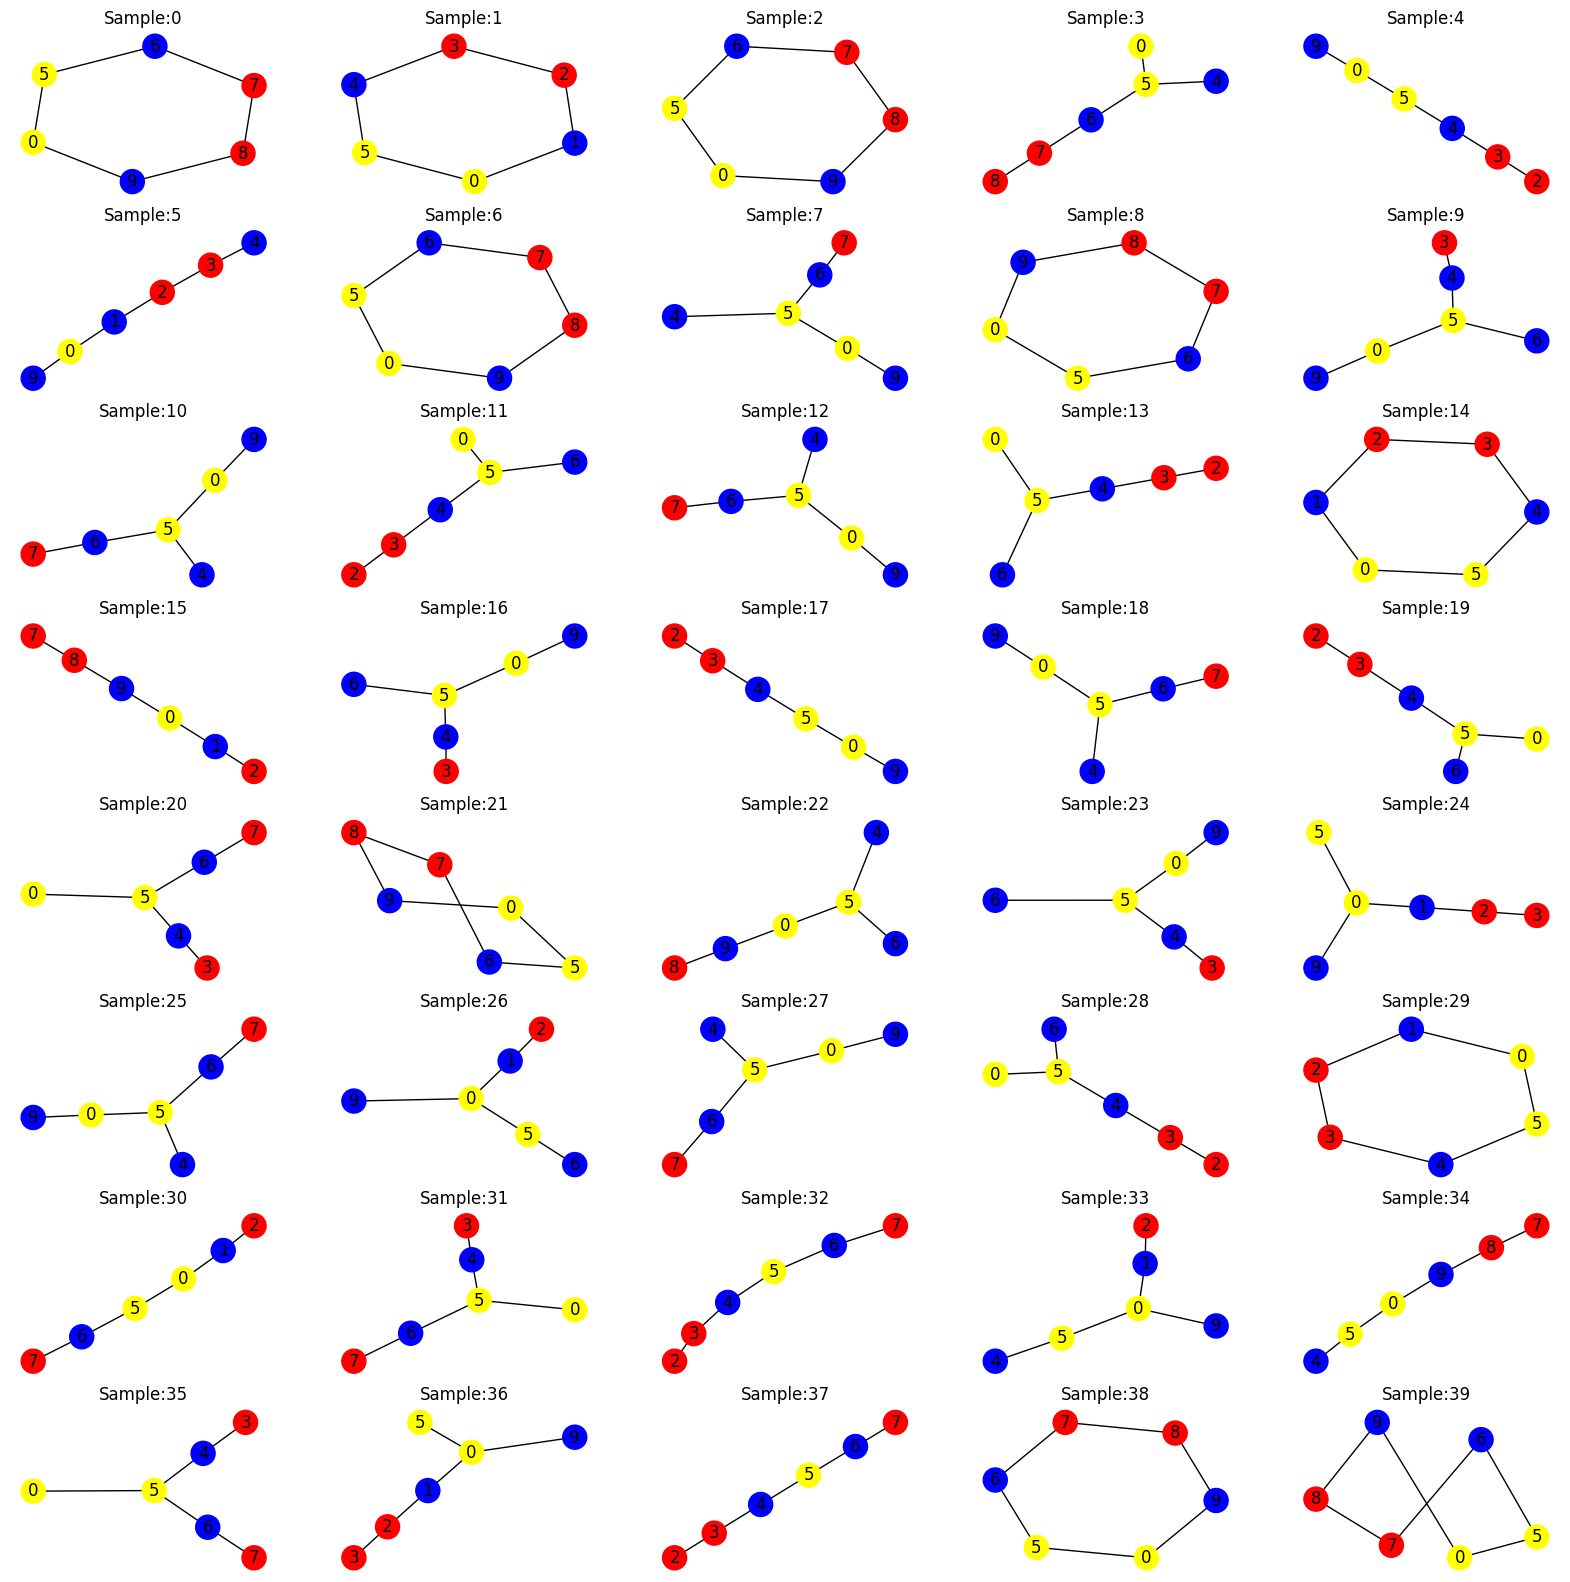

In [4]:
draw_subgraphs(G_edge_index, n, k, G_node_color)

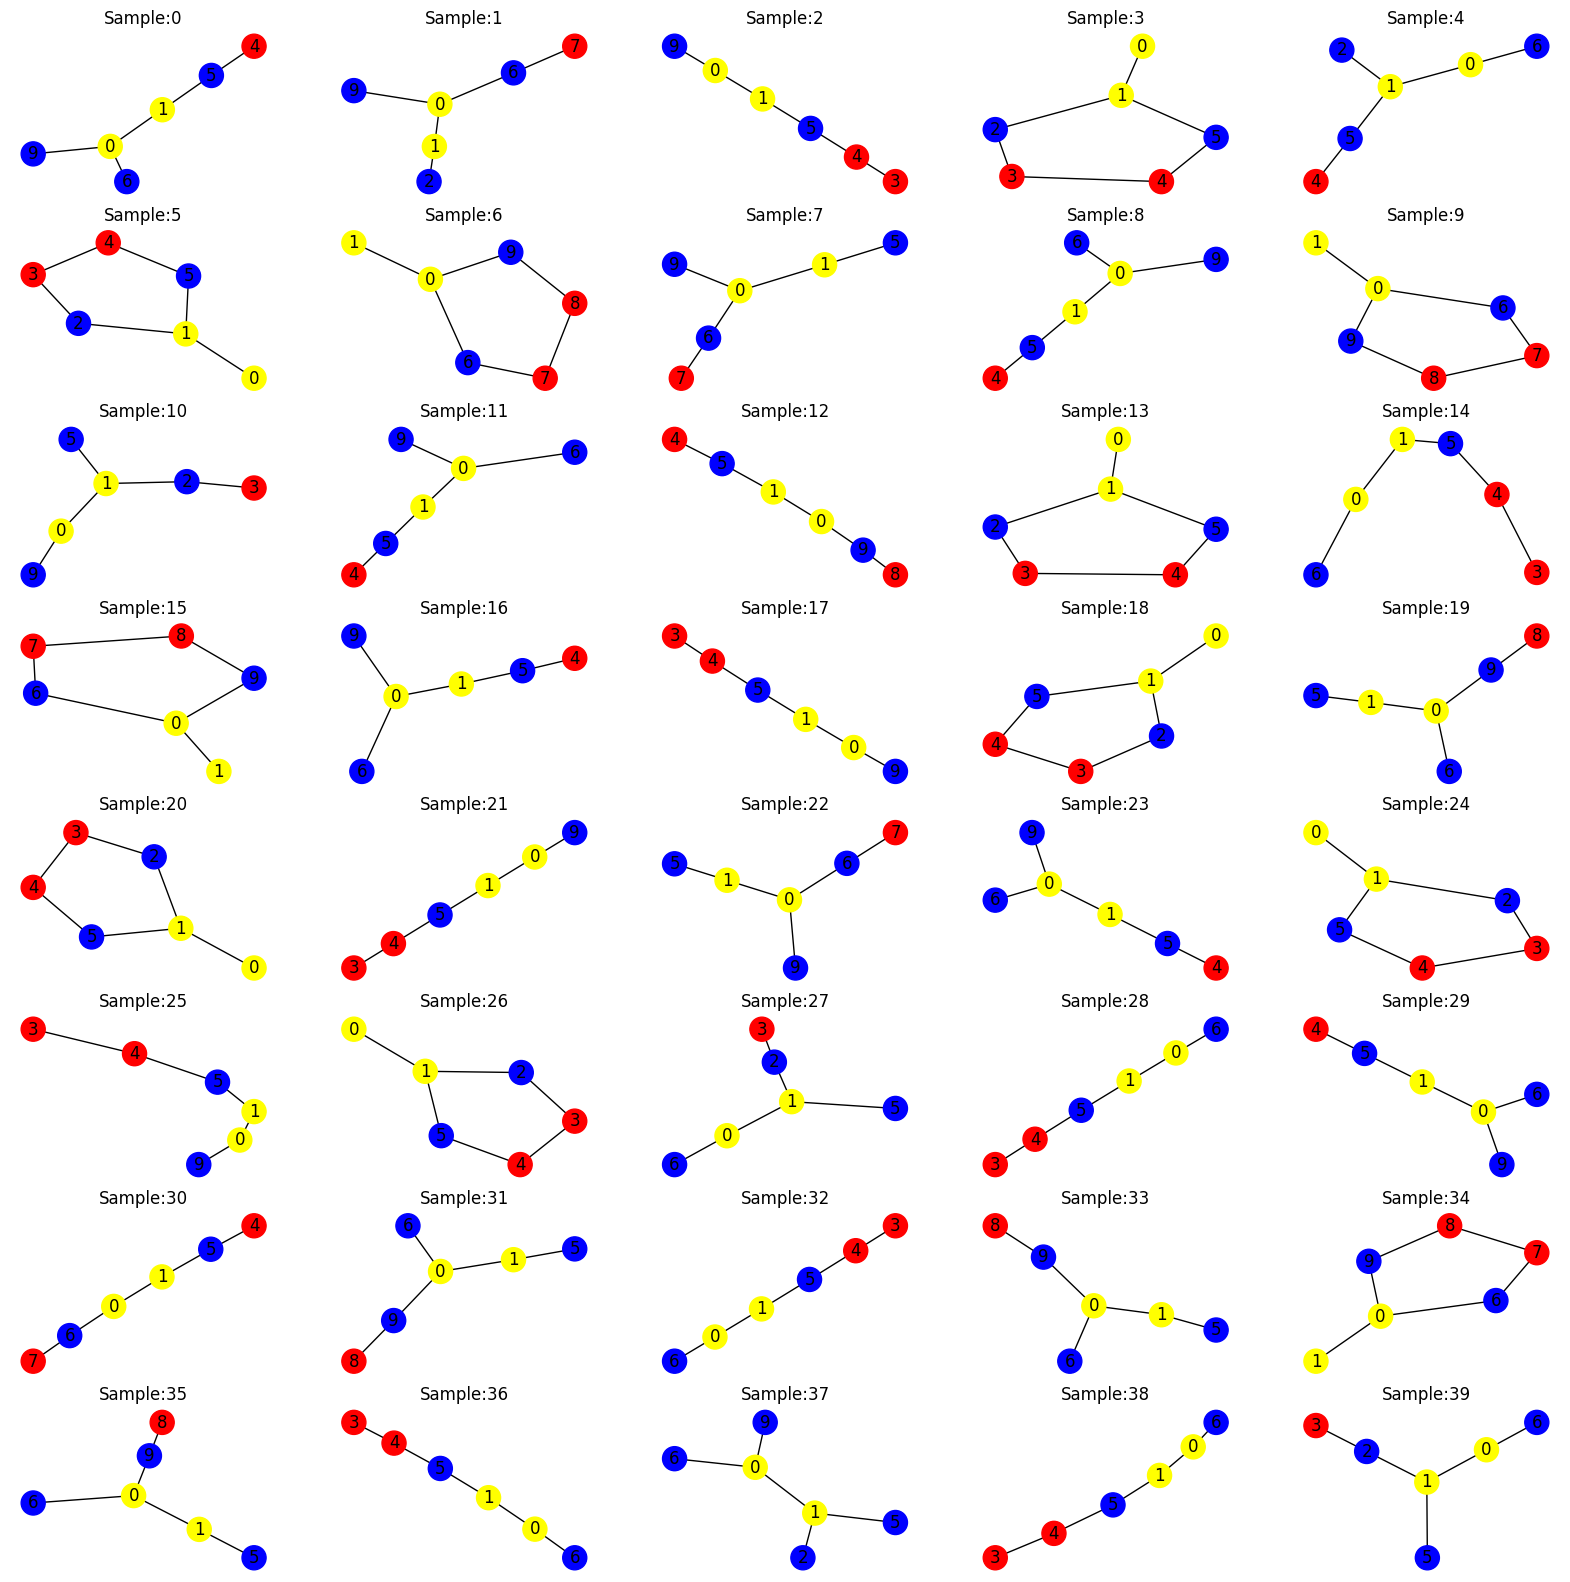

In [5]:
draw_subgraphs(H_edge_index, n, k, H_node_color)

In [6]:
def subgraph_wl_dist(edge_index,sample_size, n, k,node_color=None):
    handle = ugs_sampler.create_preproc(edge_index, n, k)
    nodes, edge_index_s, edge_ptr, graph_id = ugs_sampler.sample(handle, m_per_graph=sample_size, k=k)
    B = nodes.size(0)
    hashs = []
    for b in range(B):
        global_nodes = nodes[b].tolist()
        start, end = edge_ptr[b].item(), edge_ptr[b+1].item()
        local_edges = edge_index_s[:,start:end].T.tolist()
        G = nx.Graph()
        G.add_nodes_from(global_nodes)
        for u,v in local_edges:
            G.add_edge(global_nodes[u],global_nodes[v])

        if node_color != None:
            node_color_s = {i:node_color[i] for i in global_nodes}
            nx.set_node_attributes(G, node_color_s, "color")
            wl_hash = nx.weisfeiler_lehman_graph_hash(G,node_attr="color",iterations=k)
        else:
            wl_hash = nx.weisfeiler_lehman_graph_hash(G,iterations=k)
        hashs.append(wl_hash)
    return Counter(hashs)

In [7]:
subgraph_wl_dist(G_edge_index,30,n,6,G_node_color)

Counter({'250f5f9aa312af4993e83072a1d8245b': 8,
         '836a3f1ab0647d2b1dc28dea60fa9560': 7,
         '5fa67e0aaafa21dd9262dd06d2d754f4': 6,
         'd5a4bf780d1954112b55431f430af700': 3,
         '969ac2de38b113f1061f405e75db30bc': 2,
         'bc4df08ae247fa6d1ba51cf9b4db80f0': 2,
         '956e7af9a70729133c53d20fca41714f': 1,
         'fbba7053c14f5b92bb750e29458b1784': 1})

In [8]:
subgraph_wl_dist(H_edge_index, 30, n, 6, H_node_color)

Counter({'969ac2de38b113f1061f405e75db30bc': 12,
         '7996501f99ad050aadf04ae2cc5a8e57': 10,
         '250f5f9aa312af4993e83072a1d8245b': 3,
         '1b0746aca5e3e353a6df1b0037b52c4a': 3,
         'b8ad39c8d4adac889694950e55d9030f': 2})

In [9]:
subgraph_wl_dist(G_edge_index, 1,n, 10, G_node_color)

Counter({'20115126cf91fc3051d2ce56984b7c72': 1})

In [10]:
subgraph_wl_dist(H_edge_index, 1,n, 10, H_node_color)

Counter({'20115126cf91fc3051d2ce56984b7c72': 1})

In [11]:
Shrekhande_edge_index = torch.tensor([
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
  4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
  8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,10,10,10,10,10,10,11,11,11,11,11,11,
 12,12,12,12,12,12,13,13,13,13,13,13,14,14,14,14,14,14,15,15,15,15,15,15],
 [1, 3, 4, 5,12,15, 0, 2, 5, 6,12,13, 1, 3, 6, 7,13,14, 0, 2, 4, 7,14,15,
  0, 6, 8, 9,12,14, 1, 5, 9,10,12,13, 2, 6,10,11,13,15, 0, 3, 8,11,12,15,
  0, 4, 9,10, 8,11, 1, 5,10,11,13,14, 2, 3, 8, 9,13,15, 1, 4, 2, 7, 9,14,
  0, 3, 4, 7, 8,11, 1, 5, 6, 7,10,15, 2, 3, 6,10,14,15, 0, 1, 2, 3,12,14]
]
, dtype=torch.long)

Rooks_edge_index = torch.tensor([
 [0,1, 0,2, 0,3, 1,2, 1,3, 2,3,
  4,5, 4,6, 4,7, 5,6, 5,7, 6,7,
  8,9, 8,10, 8,11, 9,10, 9,11, 10,11,
  12,13, 12,14, 12,15, 13,14, 13,15, 14,15,
  0,4, 0,8, 0,12, 4,8, 4,12, 8,12,
  1,5, 1,9, 1,13, 5,9, 5,13, 9,13,
  2,6, 2,10, 2,14, 6,10, 6,14, 10,14,
  3,7, 3,11, 3,15, 7,11, 7,15, 11,15],
 [1,0, 2,0, 3,0, 2,1, 3,1, 3,2,
  5,4, 6,4, 7,4, 6,5, 7,5, 7,6,
  9,8, 10,8, 11,8, 10,9, 11,9, 11,10,
  13,12, 14,12, 15,12, 14,13, 15,13, 15,14,
  4,0, 8,0, 12,0, 8,4, 12,4, 12,8,
  5,1, 9,1, 13,1, 9,5, 13,5, 13,9,
  6,2, 10,2, 14,2, 10,6, 14,6, 14,10,
  7,3, 11,3, 15,3, 11,7, 15,7, 15,11]
], dtype=torch.long)


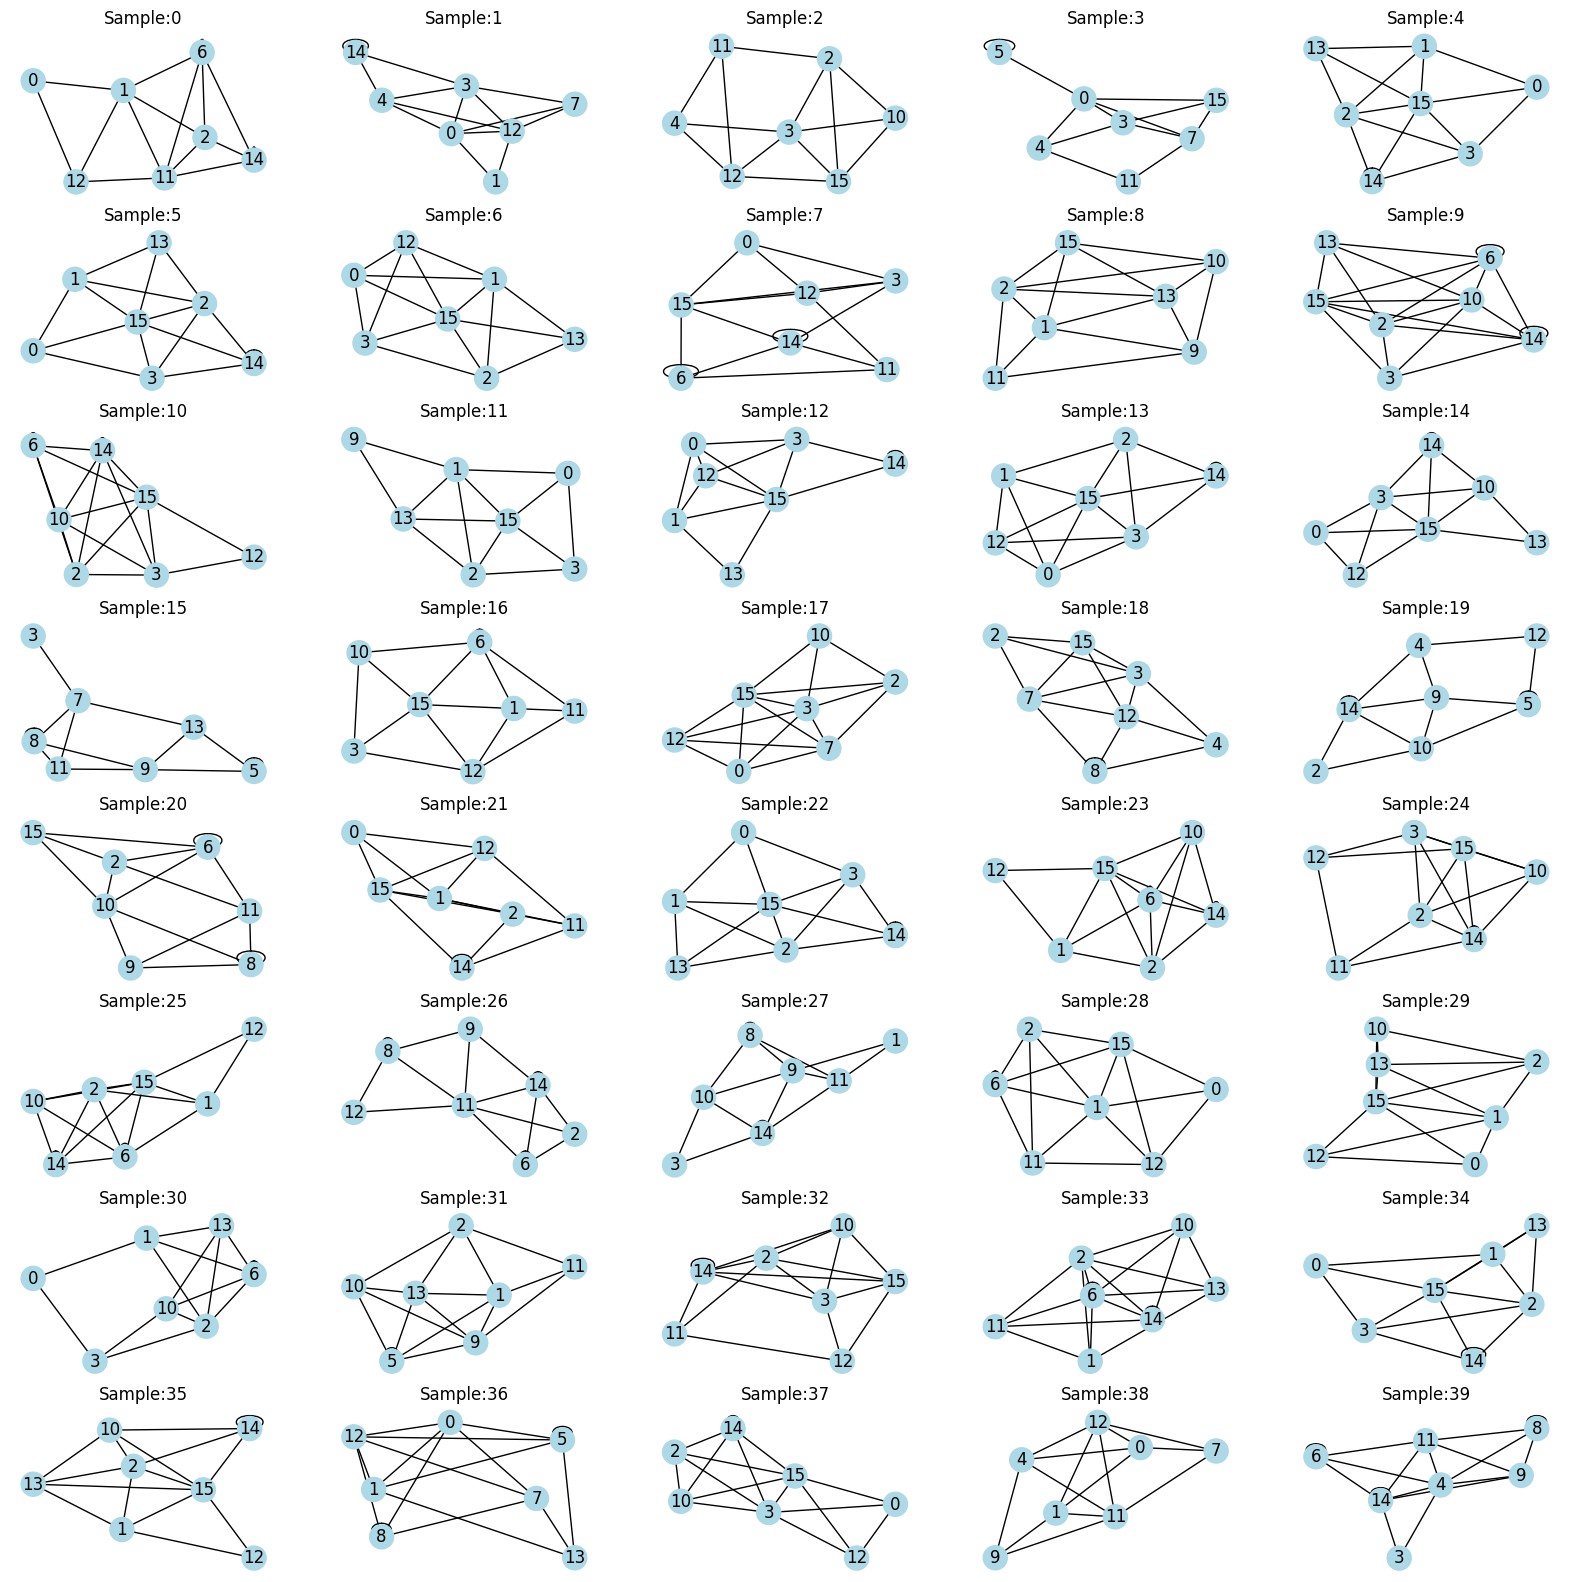

In [12]:
draw_subgraphs(Shrekhande_edge_index,16,7)

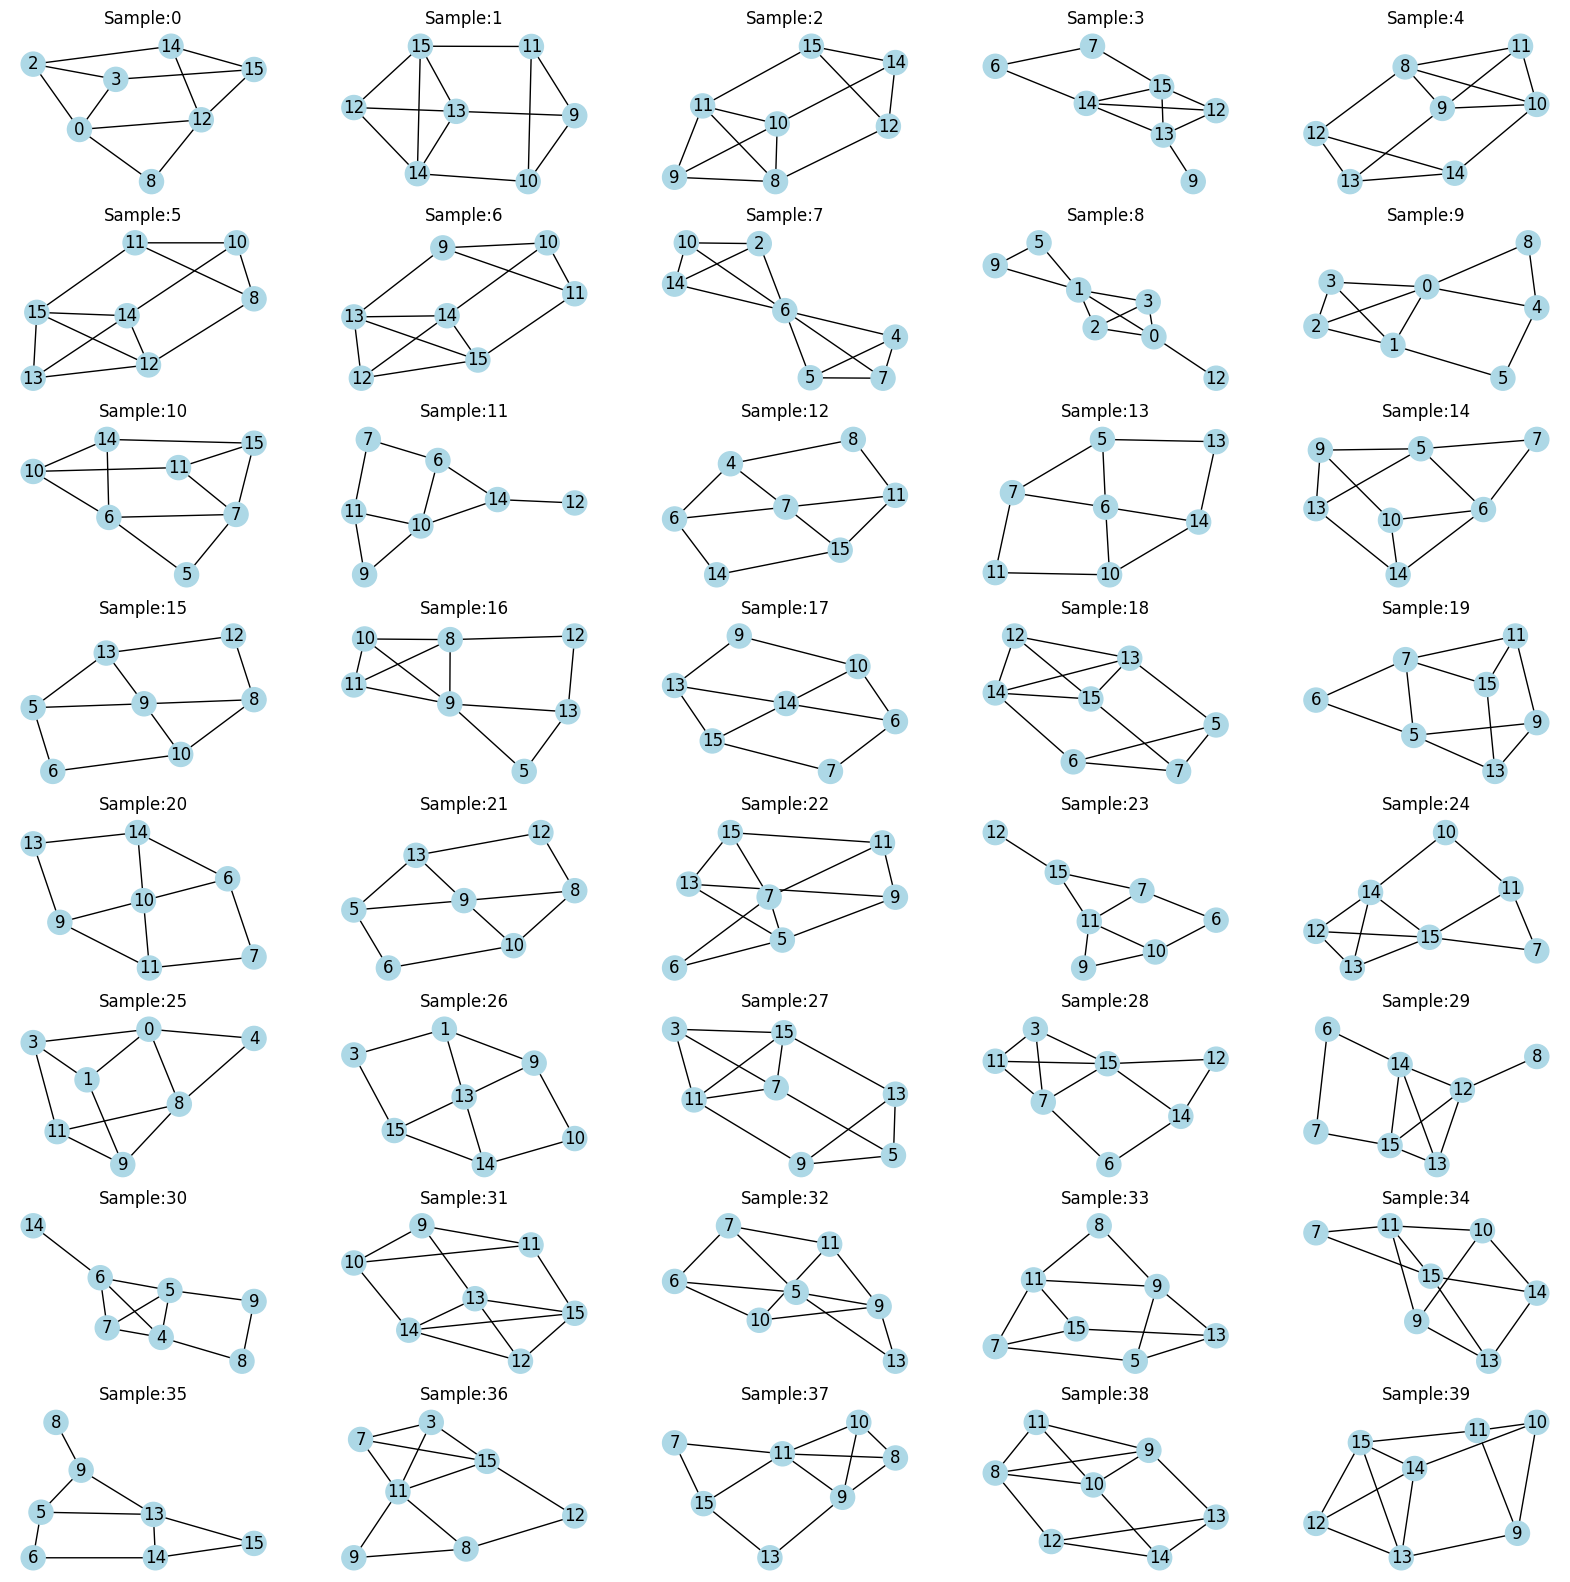

In [13]:
draw_subgraphs(Rooks_edge_index,16,7)

In [14]:
subgraph_wl_dist(Shrekhande_edge_index,30,16,7)

/home/ani/code/SS-GNN/venv/lib/python3.11/site-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributeschanged in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)


Counter({'03600d00361a6e03ef91bbdb174091fd': 5,
         'c21bcc9c48cc6e1920e71d6d7e04c403': 4,
         'f60bc6f52ce52774e8424fe4a1840695': 2,
         'b898b675dcb5b552faef89ccba9a82d5': 1,
         '4ba8e4e003ee0df4d2bd378af2fafc97': 1,
         '0560f09205155b781b4b9e2c12812eb6': 1,
         '035b1e27def0267e8f9033fdd39e3540': 1,
         'fd043dfe4ff930b76cabf78bab753faf': 1,
         'ecd68928efedf40ac669ad324b4e20a7': 1,
         '2836833f50fe5ddbdc303f1fced1ae62': 1,
         '9ee3a34042c7f86540aa21f666e3d01e': 1,
         'fb998e6dacd9bf6f9cf9d4244b9a660d': 1,
         '3c4c064469af626a44b045caafbec074': 1,
         'a57b5f76f77066757c89305cedd9e6ed': 1,
         '7be04669aa37588669c01a3455d1c271': 1,
         'a7c65a01ffc7ac2e95cb3a4ed515aeda': 1,
         '3c3d2a9fe74dba07b0804661dd8d0209': 1,
         'a2a63b48867b7fd9e35eba5550987894': 1,
         'e0759a4aff17e97c8b6887bbd08991e3': 1,
         'c86c026cb3997a2b41891613f9297393': 1,
         'fd255726e14e48f0121b21b8942494

In [15]:
subgraph_wl_dist(Rooks_edge_index,30,16,7)

Counter({'e6a3e8ebf6577b4d86204b4be0ab8962': 13,
         'afdd1459e2c9d286c3025291c3adde2b': 5,
         '7b1bf1f746156339af48423d6a88685b': 4,
         'e1f7e11a5bbf36196931ef07e8db5fd6': 3,
         'c8904ed526e4bcd1b87e9023c151f8a2': 2,
         'f4b3e2d5b9b206cf3d5ac9b0bd9fc99e': 1,
         '116d50265c930ec84eb1d9be168ce447': 1,
         'fb4142e9e085a36bdbcfdb3e32263a86': 1})

In [16]:
subgraph_wl_dist(Rooks_edge_index,30,16,7)-subgraph_wl_dist(Shrekhande_edge_index,30,16,7)

Counter({'e6a3e8ebf6577b4d86204b4be0ab8962': 10,
         'afdd1459e2c9d286c3025291c3adde2b': 5,
         '116d50265c930ec84eb1d9be168ce447': 4,
         '7b1bf1f746156339af48423d6a88685b': 4,
         'c8904ed526e4bcd1b87e9023c151f8a2': 2,
         'e1f7e11a5bbf36196931ef07e8db5fd6': 2,
         'a2d7e6433a7cd07b457f94869bbbb3e5': 1,
         'fb4142e9e085a36bdbcfdb3e32263a86': 1,
         'f4b3e2d5b9b206cf3d5ac9b0bd9fc99e': 1})

In [17]:
subgraph_wl_dist(Shrekhande_edge_index,30,16,7)-subgraph_wl_dist(Rooks_edge_index,30,16,7)

Counter({'c21bcc9c48cc6e1920e71d6d7e04c403': 4,
         'b898b675dcb5b552faef89ccba9a82d5': 3,
         '03600d00361a6e03ef91bbdb174091fd': 3,
         'd2c205cee301303aa2c22b1af581b3bf': 1,
         '1e7339497fc884cc645a2efe2eade46e': 1,
         '9531da7c0b23b767113217fb60c5f42a': 1,
         '7f92c178131063e75050882fc1f4222c': 1,
         '32cd9f05121110b39830de2c262d7058': 1,
         '83a1cba20a24d2298bda36418e4894ce': 1,
         '21fdb4abdc7797bc9afb5120fbf5d606': 1,
         'ed93711340059301408143d1437ae1d2': 1,
         'e1dfff6c54048e59de0e414dbff6cae3': 1,
         'e61e6e4b8f7cfa905c29c24827b8cac2': 1,
         'cc4b30ac8d30657f1db31e6e6b149a47': 1,
         '829af8f21e9b9b229f07fde9edac0dde': 1,
         '239aa7283754b953f36a6ab905ab2133': 1,
         '81f72395ae3727f4fe81a54cc4e834e2': 1,
         'ac2c3ba120c4c2470477838a95cb1691': 1,
         '0a759c5b39409252043df144a5428d10': 1,
         'a82c35ca967bc2d3b428bc4c25372a4a': 1,
         '7aa31e5d9712949db4f189e44a5bee

In [18]:
data = LRGBDataset("../data","Peptides-func")
handle = ugs_sampler.create_preproc(data[0].edge_index,data[0].x.size(0),10)
nodes, edge_index_s, edge_ptr, graph_id = ugs_sampler.sample(handle,50,10)
g=pyg.utils.to_networkx(data[0])

LRGBDataset(10873)
Data(x=[338, 9], edge_index=[2, 682], edge_attr=[682, 3], y=[1, 10])
torch.int64


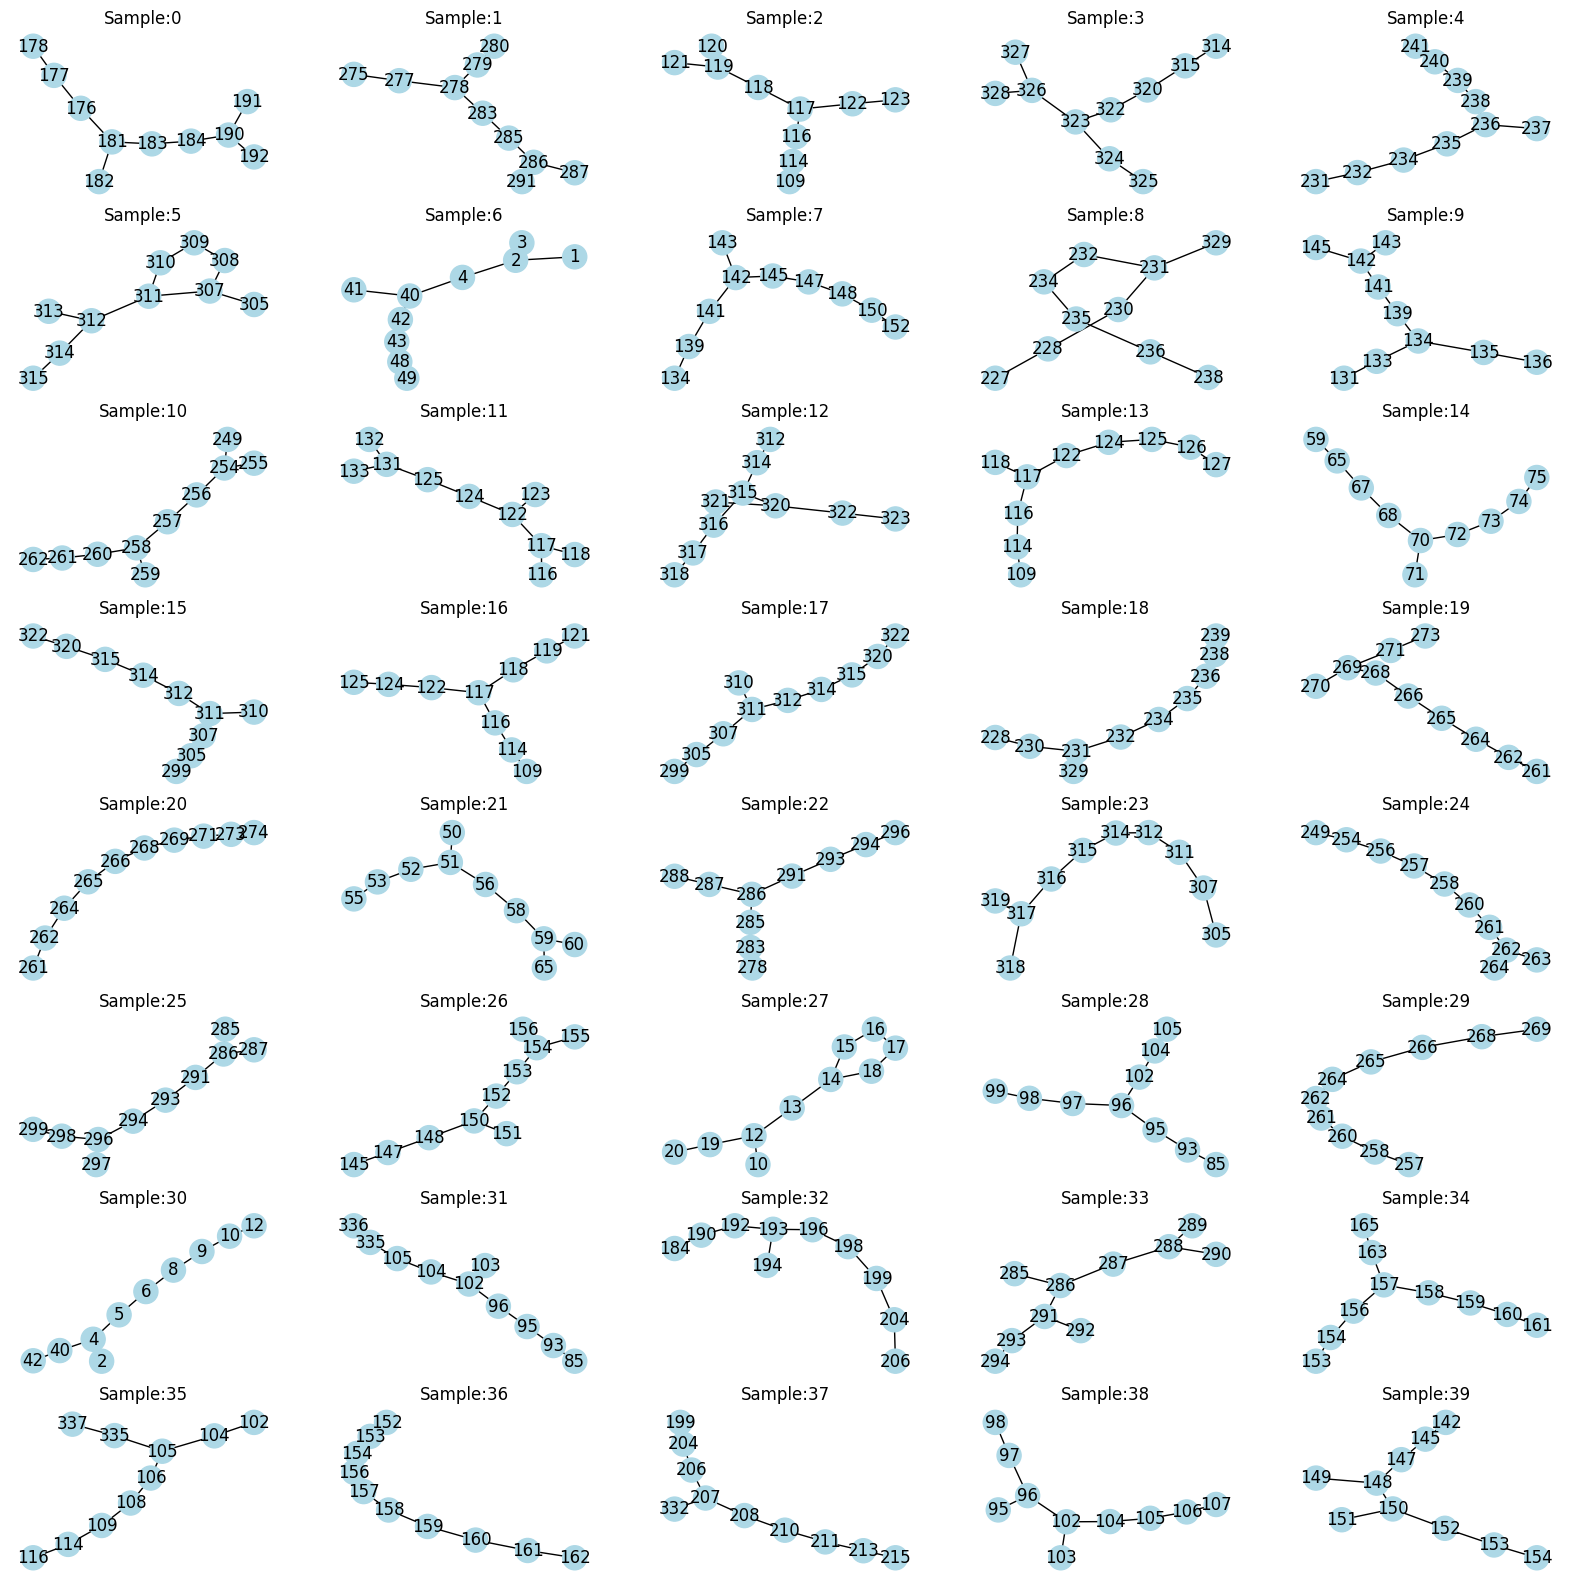

In [22]:
draw_subgraphs(data[0].edge_index, data[0].x.size(0), 10)

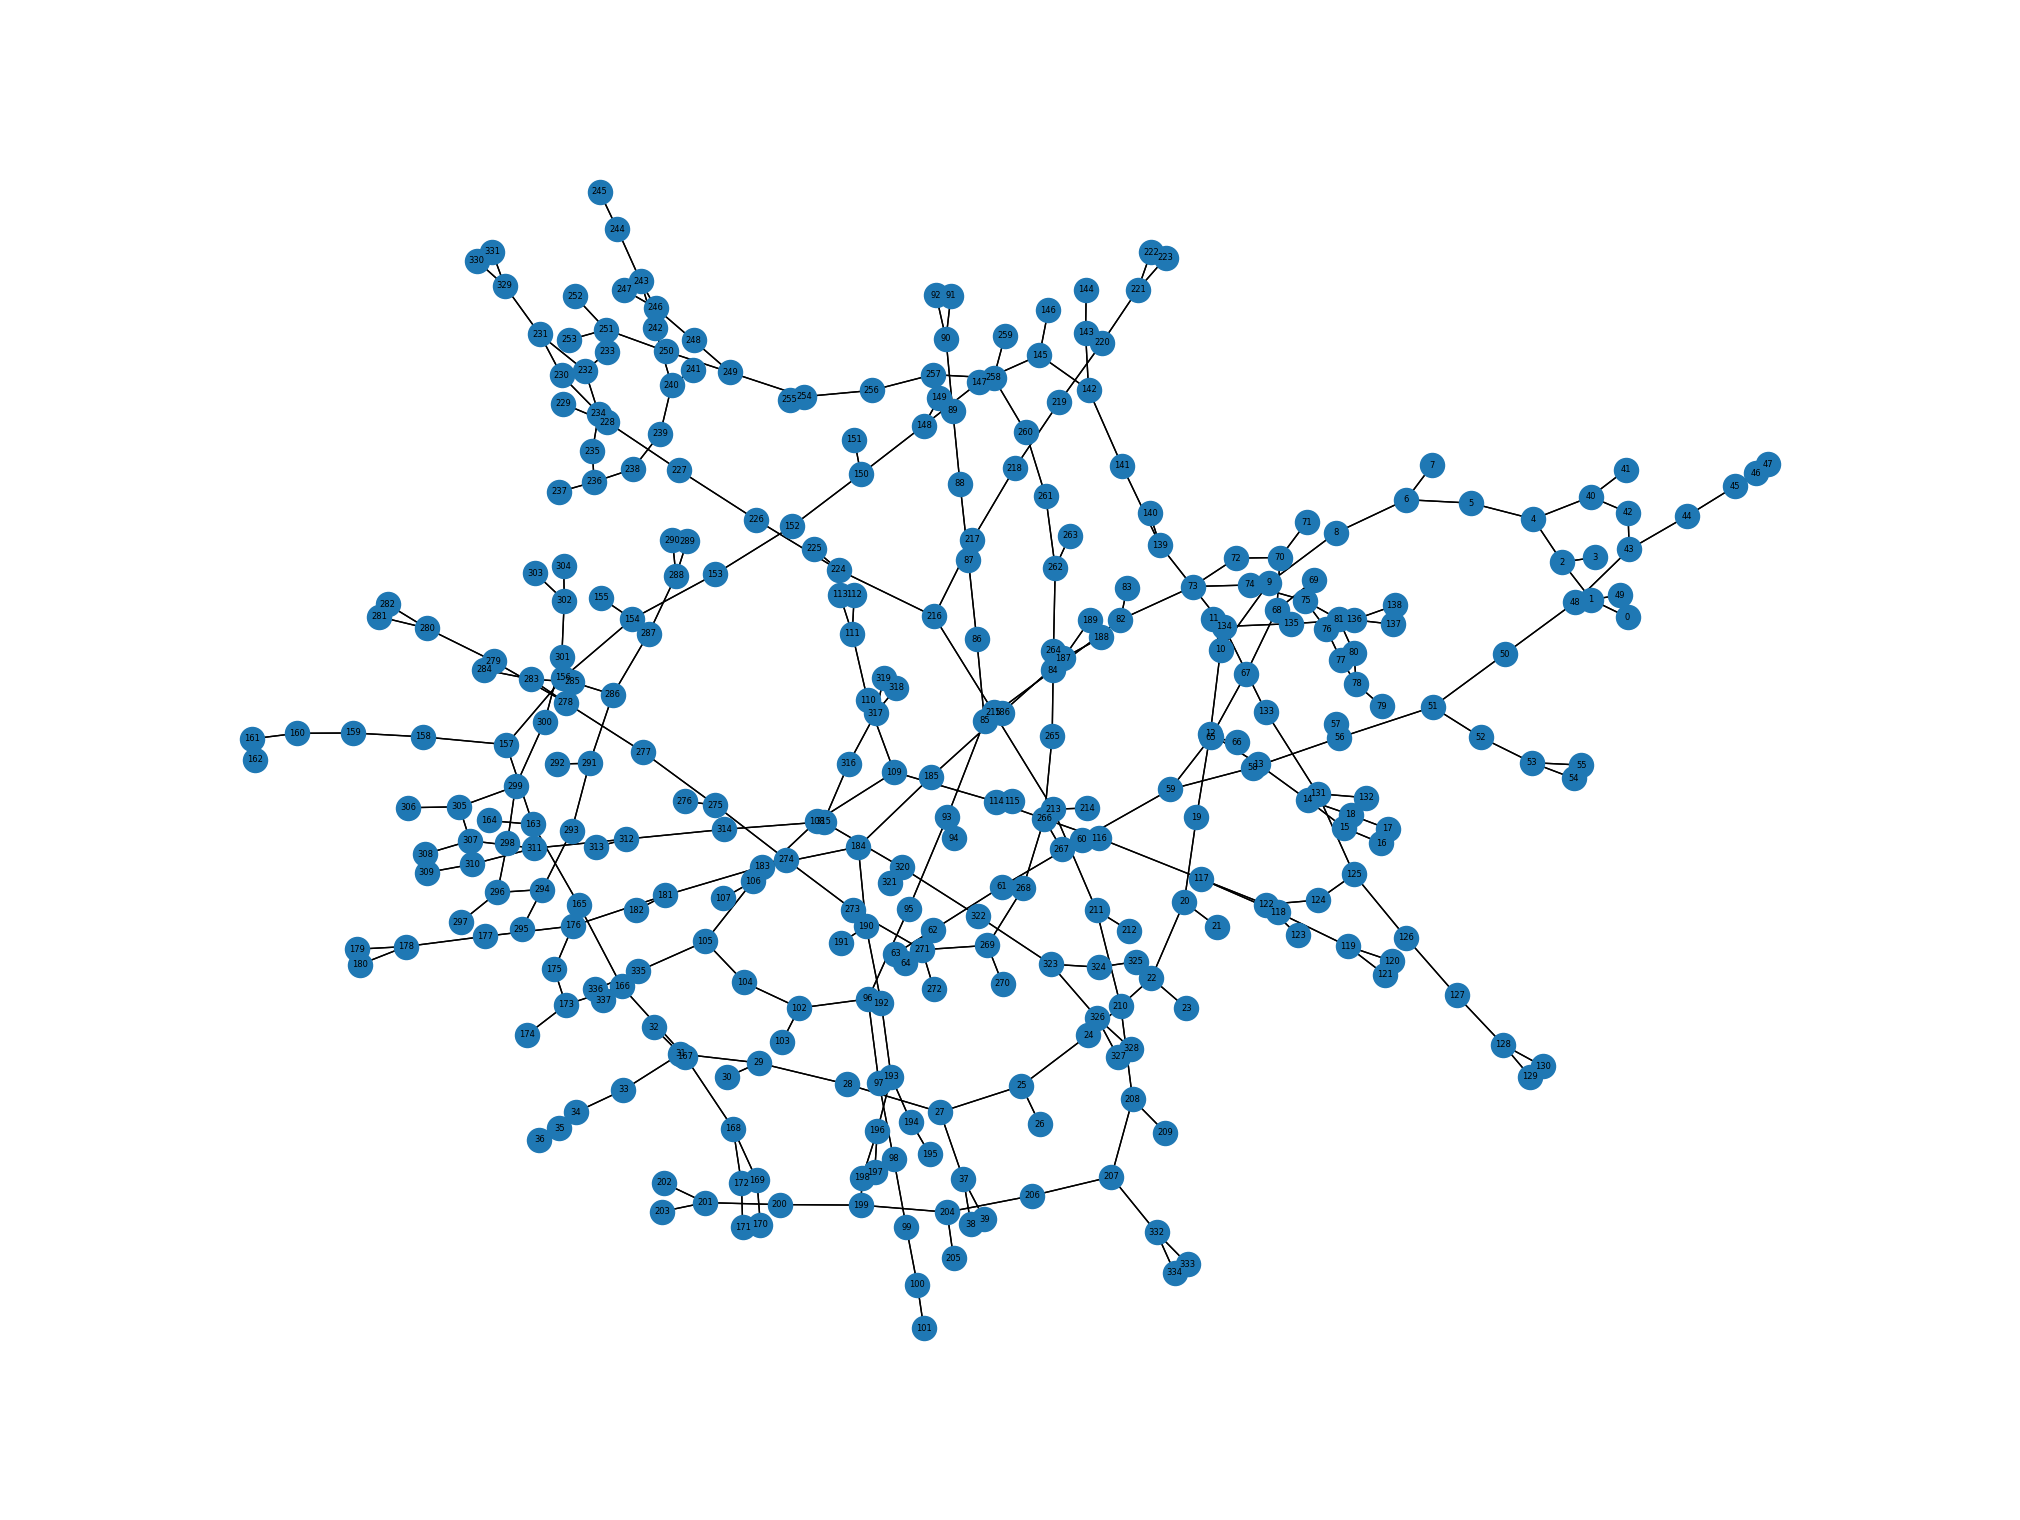

In [24]:
plt.figure(figsize=(20, 15))  # Very large figure

pos = nx.spring_layout(g, k=5, iterations=1)  # More spacing

nx.draw(g,
        node_size=300,
        font_size=6,
        with_labels=True,
        arrows=False)  # Remove arrows for cleaner look

plt.margins(0.1)  # Add margins around the graph
plt.show()

In [26]:
# Simple 3D interactive plot
def go_plot(G):
    pos = nx.spring_layout(G, dim=3)
    x, y, z = zip(*[pos[node] for node in G.nodes()])
    
    fig = go.Figure()
    fig.add_scatter3d(x=x, y=y, z=z, mode='markers+text', 
                     text=list(G.nodes()), marker=dict(size=8))
    
    for edge in G.edges():
        x_edge = [pos[edge[0]][0], pos[edge[1]][0]]
        y_edge = [pos[edge[0]][1], pos[edge[1]][1]]
        z_edge = [pos[edge[0]][2], pos[edge[1]][2]]
        fig.add_scatter3d(x=x_edge, y=y_edge, z=z_edge, mode='lines')
    fig.update_layout(width=800,height=500)
    fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False), 
        zaxis=dict(visible=False),
        bgcolor='rgba(0,0,0,0)'  # Transparent background
    ),
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper
    plot_bgcolor='rgba(0,0,0,0)'    # Transparent plot
)
    fig.write_html("graph.html")
    fig.show()

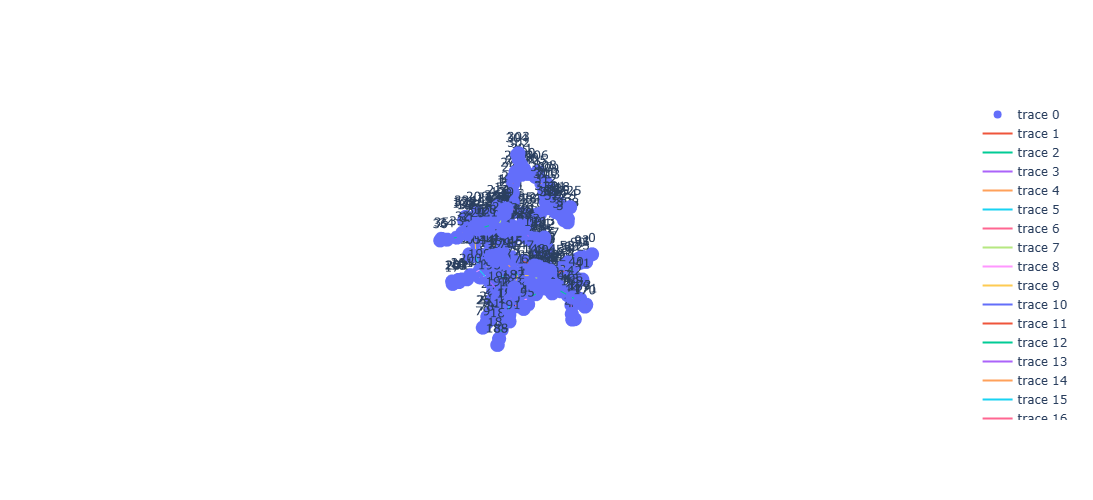

In [27]:
go_plot(g)